In [1]:
using PyPlot, LsqFit, Polynomials, Random, Statistics, CurveFit

# Numerical many-body methods - Problem Set 5
## (Quantum Monte Carlo)
Noam Ophir

# 1D Transverse Field Ising Model

*In this problem we will consider the transverse field Ising model in 1D, given by the following Hamiltonian*
$$
H=-J\sum_i \sigma^z_i \sigma^z_{i+1} - h \sum_i \sigma^x_i
$$
*As we saw in class, this model is exactly solvable (using the Jordan-Wigner transformation) and at $T = 0$ features a phase transition between an ordered ferromagnetic ground state at $h/J < 1$ and a paramagnetic state at $h/J > 1$. We also showed, that the quantum partition function $Z = \mathrm{Tr}(e^{-\beta H})$ for this model can be mapped to the classical partition function of an anistropic 2D Ising model:*
$$
Z
=
\sum_{\sigma_{i,n}^z}
\exp\left(
\sum_{x,n}
\Big[
J_x \sigma^z_{i,n}\sigma^z_{i+1,n}
+J_\tau \sigma^z_{i,n} \sigma^z_{i,n+1}
\Big]
\right)\;,
$$
*where the couplings along the spatial and imaginary time directions are given by $J_x = J \Delta \tau$ and $J_\tau  = \log(\coth(\Delta \tau h))/2$ respectively, and the size of the system along the imaginary time direction is $N_\tau = \beta/\Delta \tau$ (where $\beta$ is the inverse temperature $1/T$).*

## 1
*Adjust the code we used in class for the classical 2D Ising model, to study the 1D transverse field Ising model. Use the Wolff cluster update algorithm and think how it should be modified for the anisotropic case.*

In [18]:
### Tutorial functions
struct Point2D
    x::Int64
    tau::Int64
end

struct Chain_time_grid
    Nx::Int64
    Ntau::Int64    
end

import Base.length
function length(lat::Chain_time_grid)
    return lat.Nx*lat.Ntau
end

function PointToIndex(lat::Chain_time_grid, r::Point2D)
    @assert r.x <= lat.Nx "Site x coordinate exceeding lattice length"
    @assert r.tau <= lat.Ntau "Site y coordinate exceeding lattice width"
    
    return (r.tau-1)*lat.Nx + r.x
end

function IndexToPoint(lat::Chain_time_grid, ind::Int64)
    
    @assert ind <= length(lat) "Site index exceeding lattice size"
    
    tau = div(ind-1, lat.Nx)+1
    x = mod(ind-1, lat.Nx)+1

    return Point2D(x,tau)
end
    
function NearestNeighbors(lat::Chain_time_grid, ind::Int64)

    r = IndexToPoint(lat, ind)
    
    nn = zeros(Int64,4)
    
    xp = mod(r.x, lat.Nx)+1
    taup = mod(r.tau, lat.Ntau)+1
    xm = mod(r.x-2, lat.Nx)+1
    taum = mod(r.tau-2, lat.Ntau)+1
    
    nn[1] = PointToIndex(lat, Point2D(xm, r.tau) )
    nn[2] = PointToIndex(lat, Point2D(xp, r.tau) )
    nn[3] = PointToIndex(lat, Point2D(r.x, taum) )
    nn[4] = PointToIndex(lat, Point2D(r.x, taup) )
    
    return nn
end

NearestNeighbors (generic function with 2 methods)

In [139]:
function WolffUpdate!(lat::Chain_time_grid, config::Vector{Int64}, Jx::Float64, Jtau::Float64)
    N = length(lat)
    ind = rand(1:N)

    cluster = Int64[] 
    RealSpaceCandidates = Int64[] 
    ImTimeCandidates = Int64[] 
    newlyAdded = Int64[]

    push!(cluster, ind)
    append!(RealSpaceCandidates, NearestNeighbors(lat, ind)[1:2])
    # append!(ImTimeCandidates, NearestNeighbors(lat, ind)[3:4])
    append!(newlyAdded, NearestNeighbors(lat, ind))
    
    # Perform the Wolff algorithm until the cluster is empty
    while !isempty(newlyAdded)
        j = pop!(newlyAdded)
        
        # Skip if already in the cluster
        if j in cluster
            continue
        end
        
        if j in RealSpaceCandidates
            if config[j] == config[ind] && rand() < 1. - exp(-2*Jx)
                push!(cluster, j)
                
                nn = NearestNeighbors(lat, j)
                append!(newlyAdded, nn)
                append!(RealSpaceCandidates, nn[1:2])
                # append!(ImTimeCandidates, nn[3:4])
            end
        else
            if config[j] == config[ind] && rand() < 1. - exp(-2*Jtau)
                print("hi")
                push!(cluster, j)
                
                nn = NearestNeighbors(lat, j)
                append!(newlyAdded, nn)
                append!(RealSpaceCandidates, nn[1:2])
                # append!(ImTimeCandidates, nn[3:4])
            end
        end
    end
    
    # Flip the spins in the cluster
    config[cluster] .= 1 .- config[cluster]
end

function TFIM_MC(Nx::Int64, T::Float64, dtau::Float64, h::Float64, Nsw::Int64, Neq::Int64)
    print("Hello")

    flush(stdout)
    Jx = dtau
    Jtau = log(coth(dtau*h))/2
    @show Jtau
    beta = 1/T
    Ntau = Int64(div(beta,dtau))

    lat = Chain_time_grid(Nx,Ntau)
    m1 = Float64[]
    m2 = Float64[]
    m4 = Float64[]

    # configs[:,1:Ntau] = rand(0:1, Nx,Ntau)
    config = rand(0:1, length(lat))
    for i in range(1, stop=Neq)
        WolffUpdate!(lat, config, Jx, Jtau)
    end
    for i in range(1, stop=Nsw)
        WolffUpdate!(lat, config, Jx, Jtau)
        append!(m1,mean(abs.(mean(config,dims=1))))
        append!(m2,mean(mean(config,dims=1)) .^2)
        append!(m4,mean(mean(config,dims=1)) .^4)
    end
    return [m1, m2, m4]
end

TFIM_MC (generic function with 1 method)

In [140]:
Nx = 10
T = 10.
dtau = 0.1
h = 0.
Nsw = 10
Neq = 10

m1, m2, m4 = TFIM_MC(Nx, T, dtau, h, Nsw, Neq);

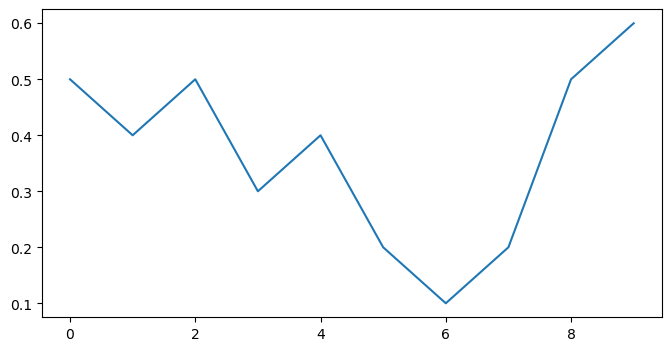

In [125]:
fig, ax = subplots(figsize=(8,4))
ax.plot(m1)

@show mean(m1)
gcf()

10×10 Matrix{Int64}:
 1  0  1  0  1  1  0  1  0  0
 0  0  1  1  0  0  0  1  0  0
 1  1  0  0  0  1  1  0  1  1
 1  0  1  0  0  1  1  1  1  0
 0  0  1  1  1  1  0  1  1  0
 0  0  0  1  1  0  0  0  1  0
 0  0  0  1  0  0  1  0  1  1
 0  0  0  1  0  0  1  0  1  1
 0  1  1  1  0  0  0  1  1  1
 0  0  0  1  1  0  0  0  0  0

## 2 

*Calculate the absolute value of the magnetization as function of $h/J$ across the phase transition for different system sizes (e.g. $N_x = 8, 16, 32$). Perform the calculation in the low temperature limit, e.g. $T/J = 0.1$, and using a small enough imaginary time step of e.g. $\Delta\tau J = 0.1$. **Be careful with the calculation of expectation values!***

In [ ]:
Nxs = [8, 16 ,32]
hs = 0:0.1:2.0

## 3

*Calculate the Binder cumulant*
$$
U_2 = 
\frac{3}{2}
\left(
1
-
\frac{1}{3}\frac{\langle m^4 \rangle}{\langle m^2 \rangle^2}
\right)$$
*as function of *h/J* across the phase transition for different system sizes (as above), and check that the curves for different system sizes indeed cross at the phase transition point $h/J = 1$. **Again, be careful with the calculation of the expectation values of the higher moments of magnetization!***